<a href="https://colab.research.google.com/github/boar1ang/big-data-challenge/blob/master/Amzn_OfficeProds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Install Java, Spark, and Findspark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()


In [40]:
!wget https://jdbc.postgresql.org/download/postgresql-42.2.9.jar

--2020-05-15 21:55:49--  https://jdbc.postgresql.org/download/postgresql-42.2.9.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 914037 (893K) [application/java-archive]
Saving to: ‘postgresql-42.2.9.jar.2’

postgresql-42.2.9.j 100%[===================>] 892.61K  --.-KB/s    in 0.1s    

2020-05-15 21:55:49 (8.53 MB/s) - ‘postgresql-42.2.9.jar.2’ saved [914037/914037]



In [0]:
# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Amzn_OfficeProds").config("spark.driver.extraClassPath","/content/postgresql-42.2.9.jar").getOrCreate()

In [42]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url ="https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Office_Products_v1_00.tsv.gz"
spark.sparkContext.addFile(url)
office_prods_df = spark.read.csv(SparkFiles.get("amazon_reviews_us_Office_Products_v1_00.tsv.gz"), sep="\t", header=True)


# Show DataFrame
office_prods_df.show(10)

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   43081963|R18RVCKGH1SSI9|B001BM2MAC|     307809868|Scotch Cushion Wr...| Office Products|          5|            0|          0|   N|                Y|          Five Stars|      Great product.| 2015-08-31|
|         US|   10951564|R3L4L6LW1PUOFY|B00DZYEXPQ|      75004341|Dust-Off Compress...| Office Products|          5|    

In [43]:
office_prods_df.describe()

DataFrame[summary: string, marketplace: string, customer_id: string, review_id: string, product_id: string, product_parent: string, product_title: string, product_category: string, star_rating: string, helpful_votes: string, total_votes: string, vine: string, verified_purchase: string, review_headline: string, review_body: string, review_date: string]

Clean up

In [44]:
print(office_prods_df.count())
office_prods_df = office_prods_df.dropna()
print(office_prods_df.count())
office_prods_df = office_prods_df.dropDuplicates()
print(office_prods_df.count())

2642434
2642195
2642195


Filter out reviews on unverified purchases

In [45]:
# Load sql column function
from pyspark.sql.functions import col

# Filter for only columns with verified purchases
office_prods_df = office_prods_df.filter(col("verified_purchase")  == 'Y')
office_prods_df.show(5)

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   14928712|R100TJO6JFCAMT|B004TU0IC2|     137501734|1 LEXMARK TONER R...| Office Products|          5|            0|          0|   N|                Y|Works perfectly, ...|Item as described...| 2013-07-19|
|         US|   12999038|R100Y1XN4A4F4V|B0055MI230|     305431275|Canon CLI-226 3 C...| Office Products|          5|    

In [46]:
print(office_prods_df.count())

2257685


Cleaning resulted in 384,749 fewer rows

Reduce DataFrame by dropping unnecessary columns and splitting 'review' data off from 'product' data

In [47]:
ver_OffProdReviews_df = office_prods_df.select(["customer_id", "review_id", "product_id", "product_parent", "product_title", "product_category", "star_rating", "helpful_votes", "total_votes", "vine", "review_headline", "review_body", "review_date" ])
ver_OffProdReviews_df.show(5)

+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+--------------------+--------------------+-----------+
|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|     review_headline|         review_body|review_date|
+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+--------------------+--------------------+-----------+
|   14928712|R100TJO6JFCAMT|B004TU0IC2|     137501734|1 LEXMARK TONER R...| Office Products|          5|            0|          0|   N|Works perfectly, ...|Item as described...| 2013-07-19|
|   12999038|R100Y1XN4A4F4V|B0055MI230|     305431275|Canon CLI-226 3 C...| Office Products|          5|            0|          0|   N|          Five Stars|As described and ...| 2015-06-19|
|   19095535|R100YGDYQ4Z1D3|B0039OWAZC|     110562

In [48]:
products_reviewed_df = office_prods_df.select(["product_id", "product_parent", "product_title", "product_category", "review_id"])
products_reviewed_df.show(5)

+----------+--------------+--------------------+----------------+--------------+
|product_id|product_parent|       product_title|product_category|     review_id|
+----------+--------------+--------------------+----------------+--------------+
|B004TU0IC2|     137501734|1 LEXMARK TONER R...| Office Products|R100TJO6JFCAMT|
|B0055MI230|     305431275|Canon CLI-226 3 C...| Office Products|R100Y1XN4A4F4V|
|B0039OWAZC|     110562620|50 Blank Greeting...| Office Products|R100YGDYQ4Z1D3|
|B000IGMB5I|      76268412|Cross Classic Cen...| Office Products|R1028UG5FPCGDR|
|B008HBFADQ|     365473002|Fujitsu ScanSnap ...| Office Products|R1031OV54Z62RO|
+----------+--------------+--------------------+----------------+--------------+
only showing top 5 rows



In [49]:
reviews_df = ver_OffProdReviews_df.select(["review_id", "star_rating", "helpful_votes", "total_votes", "vine", "review_headline", "review_body", "review_date", "customer_id"])
reviews_df.show(5)

+--------------+-----------+-------------+-----------+----+--------------------+--------------------+-----------+-----------+
|     review_id|star_rating|helpful_votes|total_votes|vine|     review_headline|         review_body|review_date|customer_id|
+--------------+-----------+-------------+-----------+----+--------------------+--------------------+-----------+-----------+
|R100TJO6JFCAMT|          5|            0|          0|   N|Works perfectly, ...|Item as described...| 2013-07-19|   14928712|
|R100Y1XN4A4F4V|          5|            0|          0|   N|          Five Stars|As described and ...| 2015-06-19|   12999038|
|R100YGDYQ4Z1D3|          4|            0|          0|   N|Great for at home...|I used these to p...| 2012-07-31|   19095535|
|R1028UG5FPCGDR|          5|            0|          0|   N|            Good Pen|I like the brush ...| 2013-05-04|   20715457|
|R1031OV54Z62RO|          5|            1|          1|   N|Great document sc...|Great scanner for...| 2013-05-28|   14

Limit to reviews of verified purchases

In [50]:
from pyspark.sql.functions import countDistinct
unique_prods = products_reviewed_df.agg(countDistinct("product_id")).collect()
unique_prods

[Row(count(DISTINCT product_id)=283442)]

In [51]:
from pyspark.sql.functions import expr
reviews_df = reviews_df.withColumn("star_rating", reviews_df.star_rating.cast("int"))
reviews_df.describe()

DataFrame[summary: string, review_id: string, star_rating: string, helpful_votes: string, total_votes: string, vine: string, review_headline: string, review_body: string, review_date: string, customer_id: string]

In [0]:
import pandas as pd
# reviews_df = pd.to_numeric(reviews_df['star_rating'], errors='coerce')

In [53]:
rating_dist = reviews_df.groupBy("star_rating")\
  .count()\
  .show()


+-----------+-------+
|star_rating|  count|
+-----------+-------+
|          1| 227706|
|          3| 162984|
|          5|1401812|
|          4| 355438|
|          2| 109745|
+-----------+-------+



In [54]:
rating_dist_df = pd.DataFrame(rating_dist)
rating_dist_df.dtypes

Series([], dtype: object)

In [0]:
# rating_dist_df = rating_dist.to_frame() 
# rating_dist_df = rating_dist_df.rename(columns={"star_rating", "count"})
# rating_dist_df

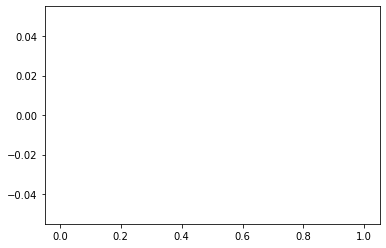

In [56]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
# plt.style.use('classic')

plt.hist(rating_dist_df)
plt.show()
# ['star_rating'] = reviews_df['star_rating'].astype(int)

Count of unique office products = 283,442

In [59]:
print(pd.__version__)

1.0.3


Postgres Setup

In [0]:
#Configure setting for Amazon RDS
mode="append"
jdbc_url = "jdbc:postgresql://myaws-postgres.cg43u4ybmrtw.us-east-1.rds.amazonaws.com:5432/my_amzn_reviews_db"
config= {"user": "root",
         "password": "20200510",
         "driver": "org.postgresql.Driver"}

Write dataframes to target tables in my_amzn_reviews_db

In [0]:
reviews_df.write.jdbc(url=jdbc_url, table="reviews", mode=mode, properties=config)

In [0]:
products_reviewed_df.write.jdbc(url=jdbc_url, table="products", mode=mode, properties=config)